# Convolutional Neural Network for Malware Revealer + Ensembling

In this notebook we trained three convolutonal neural networks based on 'SqueezeNet1_1' to classify our dataset of malwares/benign files, the training was done on different subset of the data to use ensembling technics later.

This training part was done after preprocessing the executables, it consisted of transforming the binaries to images. You can find out more about this in our [github project](https://github.com/youben11/malware-revealer).

## Load the necessary libraries 

In [1]:
import os
import torch
import torch.optim as optim
from torchvision import transforms, models
import torchvision 
from collections import OrderedDict
from torch import nn 
import matplotlib.pyplot as plt
import numpy as np

## Load the dataset

In [2]:
datasets_dir = "../input/malwarerevealer3subsetimages/malware-revealer-3subset-images/"
data1 = datasets_dir + "data1"
data2 = datasets_dir + "data2"
data3 = datasets_dir + "data3"
datasets = ["data1", "data2", "data3"]
data_path = {
    'data1': data1,
    'data2': data2,
    'data3': data3,
}

In [3]:
data_transforms = transforms.Compose([
    transforms.Resize(224),              
    transforms.ToTensor(),
])

image_datasets = {
    name: torchvision.datasets.ImageFolder(data_path[name], transform=data_transforms) for name in datasets
}

## Split the dataset into training, validation and test set
A good practice is to split the dataset into : 
- Training set : the weights of our neural network will be trained on this set of training examples and it will be the larger portion of the data set 70% .
- Validation set : to measure the progress of the training and be able to tune the hyper parameters more effectively and watch out the the training progress in order to detect any underfitting or overfitting behaviours , it will be about 20% of our original data set .
- The test set : this one will remain untouchable and will not be involved in any training ,and it's used to purely test the performance of the trained model , the size will be 10% from our original data set.

In [4]:
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
valid_size_and_test = 0.3

targets = {name: image_datasets[name].targets for name in datasets}

dataloaders = {}
for name in datasets:
    train_idx, rest_idx= train_test_split(np.arange(len(targets[name])), test_size=valid_size_and_test, random_state=42, shuffle=True, stratify=targets[name])
    test_size = int(len(rest_idx) * valid_size_and_test)
    valid_idx, test_idx = rest_idx[:test_size], rest_idx[test_size:]
    
    dataloaders[name] = {
        'trainLoader' : torch.utils.data.DataLoader(image_datasets[name], batch_size=32,sampler=SubsetRandomSampler(train_idx)),
        'validLoader' : torch.utils.data.DataLoader(image_datasets[name], batch_size=32,sampler=SubsetRandomSampler(valid_idx)),
        'testLoader' :  torch.utils.data.DataLoader(image_datasets[name], batch_size=32,sampler=SubsetRandomSampler(test_idx)),
    }

## Instanciating a pretrained Squeezenet1_1

We need to adjust the final layer so it just output 2 classes

In [5]:
def new_squeezenet1_1(device):
    model = models.squeezenet1_1(pretrained=True)
    # Customizing the squeezenet architecture
    features = list(model.classifier.children())
    features[1] = nn.Conv2d(model.classifier[1].in_channels, 2, kernel_size=(1,1))
    model.classifier = nn.Sequential(*features)
    model.num_classes = 2
    # make sure gradient is calcualted
    for param in model.parameters():
        param.requires_grad = True
    model.to(device)
    
    return model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = new_squeezenet1_1(device)
print(model.classifier[1].in_channels)
print( model.classifier[1].out_channels)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /tmp/.cache/torch/checkpoints/squeezenet1_1-f364aa15.pth
100%|██████████| 4966400/4966400 [00:00<00:00, 33820397.17it/s]


512
2


## Define the hyper parameters

In [6]:
epochs = 90
steps = 0
running_loss = 0
print_every = 26

## Train the 3 models

In [7]:
training_losses = {}
validation_losses = {}
for name in dataloaders.keys():
    dataloader = dataloaders[name]
    model = new_squeezenet1_1(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adadelta(model.parameters(), lr=0.002)
    
    min_val_loss = np.inf
    training_loss = []
    validation_loss = []
    for e in range(epochs):
        running_loss = 0
        model.train() 

        for ii, (inputs, labels) in enumerate(dataloader['trainLoader']):
            steps += 1
            #move the labels and inputs to the device ( GPU or CPU )
            inputs,labels = inputs.to(device), labels.to(device)
            # get rid of accumulated gradient 
            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # cumulating the loss 
            running_loss += loss.item()

            if steps % print_every == 0:
                model.eval()
                vlost = 0
                accuracy=0
                # no grad because we are looping in the validation set we don't need to update the weights ( this data is not used for training the model )
                with torch.no_grad():
                    for ii, (inputs2,labels2) in enumerate(dataloader['validLoader']):

                        optimizer.zero_grad()
                        inputs2, labels2 = inputs2.to(device) , labels2.to(device)
                        model.to(device)
                        with torch.no_grad():    
                            outputs = model.forward(inputs2)
                            vlost = criterion(outputs,labels2)
                            ps = torch.exp(outputs).data
                            equality = (labels2.data == ps.max(1)[1])
                            accuracy += equality.type_as(torch.FloatTensor()).mean()

                    vlost = vlost / len(dataloader['validLoader'])
                    accuracy = accuracy /len(dataloader['validLoader'])
                    #print some statistics 
                    training_loss.append(running_loss/print_every)
                    validation_loss.append(vlost)
                    print("Epoch: {}/{}... ".format(e+1, epochs),
                          "Training Loss: {:.4f} | ".format(running_loss/print_every),
                          "Validation Lost {:.4f} | ".format(vlost),
                           "Accuracy: {:.4f}".format(accuracy))
                    # checkpointing the best model
                    if vlost < min_val_loss:
                        print("New validation loss, checkpointing ...")
                        min_val_loss = vlost
                        torch.save(model.state_dict(), 'squeezenet1_1_%s.pth' % name)
                        
            running_loss = 0
    
    # saving losses for analyzing training behaviour
    training_losses[name] = training_loss
    validation_losses[name] = validation_loss

print("\nTraining process finished ")
 


Epoch: 1/90...  Training Loss: 0.0257 |  Validation Lost 0.0564 |  Accuracy: 0.6493
New validation loss, checkpointing ...
Epoch: 1/90...  Training Loss: 0.0246 |  Validation Lost 0.0515 |  Accuracy: 0.6615
New validation loss, checkpointing ...


/opt/conda/lib/python3.6/site-packages/PIL/Image.py:2600: DecompressionBombWarning: Image size (134583201 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch: 1/90...  Training Loss: 0.0221 |  Validation Lost 0.0482 |  Accuracy: 0.6745
New validation loss, checkpointing ...
Epoch: 2/90...  Training Loss: 0.0200 |  Validation Lost 0.0503 |  Accuracy: 0.7092
Epoch: 2/90...  Training Loss: 0.0167 |  Validation Lost 0.0402 |  Accuracy: 0.7005
New validation loss, checkpointing ...
Epoch: 2/90...  Training Loss: 0.0210 |  Validation Lost 0.0552 |  Accuracy: 0.7318
Epoch: 3/90...  Training Loss: 0.0250 |  Validation Lost 0.0605 |  Accuracy: 0.7344
Epoch: 3/90...  Training Loss: 0.0179 |  Validation Lost 0.0379 |  Accuracy: 0.7682
New validation loss, checkpointing ...
Epoch: 3/90...  Training Loss: 0.0201 |  Validation Lost 0.0409 |  Accuracy: 0.7778
Epoch: 3/90...  Training Loss: 0.0203 |  Validation Lost 0.0318 |  Accuracy: 0.7622
New validation loss, checkpointing ...
Epoch: 4/90...  Training Loss: 0.0160 |  Validation Lost 0.0295 |  Accuracy: 0.7769
New validation loss, checkpointing ...
Epoch: 4/90...  Training Loss: 0.0229 |  Validati

/opt/conda/lib/python3.6/site-packages/PIL/Image.py:2600: DecompressionBombWarning: Image size (111746041 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Epoch: 1/90...  Training Loss: 0.0267 |  Validation Lost 0.0537 |  Accuracy: 0.6216
New validation loss, checkpointing ...
Epoch: 1/90...  Training Loss: 0.0224 |  Validation Lost 0.0503 |  Accuracy: 0.6723
New validation loss, checkpointing ...
Epoch: 1/90...  Training Loss: 0.0266 |  Validation Lost 0.0401 |  Accuracy: 0.7071
New validation loss, checkpointing ...
Epoch: 1/90...  Training Loss: 0.0273 |  Validation Lost 0.0490 |  Accuracy: 0.7099
Epoch: 2/90...  Training Loss: 0.0206 |  Validation Lost 0.0526 |  Accuracy: 0.7374
Epoch: 2/90...  Training Loss: 0.0224 |  Validation Lost 0.0411 |  Accuracy: 0.7360
Epoch: 2/90...  Training Loss: 0.0218 |  Validation Lost 0.0465 |  Accuracy: 0.7478
Epoch: 3/90...  Training Loss: 0.0174 |  Validation Lost 0.0227 |  Accuracy: 0.7630
New validation loss, checkpointing ...
Epoch: 3/90...  Training Loss: 0.0183 |  Validation Lost 0.0540 |  Accuracy: 0.7556
Epoch: 3/90...  Training Loss: 0.0210 |  Validation Lost 0.0268 |  Accuracy: 0.7658
Epoc

## Plot some statistics about the trainings bahaviour
This section will help in tracking the training behaviour because ploting the data makes it so easy to see the trends and get sense about the overall trend to make decision about the next step in order to enhance the performance of the network .

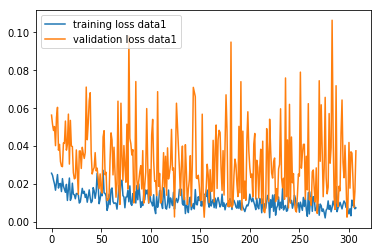

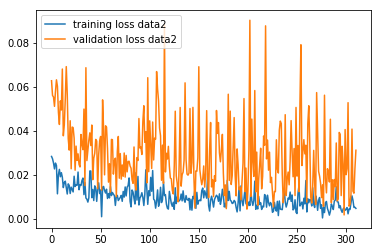

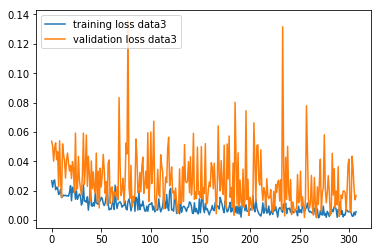

In [8]:
for name in training_losses.keys():
    training_loss = training_losses[name]
    validation_loss = validation_losses[name]
    x = [i for i in range(len(validation_loss))]
    plt.plot(x, training_loss)
    plt.plot(x, validation_loss)
    plt.legend(['training loss %s' % name, 'validation loss %s' % name], loc='upper left')
    plt.show()

## Tests the 3 models
It's mendatory to test the model on whole unseen sub set of the data to judge its performance .

In [9]:
def load_checkpointed_model(checkpoint_file):
    if checkpoint_file == None:
        return new_squeezenet1_1(device)
    
    model = new_squeezenet1_1(device)
    state_dict = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(state_dict)
    return model


def get_overall_accuracy(model, testloader):
    correct = 0
    total = 0
    total_per_label = {0: 0, 1: 0}
    correct_per_label = {0: 0, 1: 0}
    model.to(device)
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            zero_indices = (labels == 0).cpu()
            one_indices = (labels == 1).cpu()
            total_per_label[0] += np.count_nonzero(zero_indices)
            total_per_label[1] += np.count_nonzero(one_indices)
            correct_per_label[0] += np.count_nonzero(labels[zero_indices].cpu() == predicted[zero_indices].cpu())
            correct_per_label[1] += np.count_nonzero(labels[one_indices].cpu() == predicted[one_indices].cpu())

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
    print("Benings {correct}/{total}".format(correct=correct_per_label[0], total=total_per_label[0]))
    print("Malwares {correct}/{total}".format(correct=correct_per_label[1], total=total_per_label[1]))
    
    
for name in datasets:
    checkpoint_file = "squeezenet1_1_%s.pth" % name
    model = load_checkpointed_model(checkpoint_file)
    print("Testing model trained on data: %s" % name)
    get_overall_accuracy(model, dataloaders[name]['testLoader'])

Testing model trained on data: data1
Accuracy of the network on the test images: 82 %
Benings 322/396
Malwares 384/455
Testing model trained on data: data2
Accuracy of the network on the test images: 88 %
Benings 333/395
Malwares 426/461
Testing model trained on data: data3
Accuracy of the network on the test images: 89 %
Benings 359/393
Malwares 401/460


# Ensembling

In this section, we are gonna make use of the 3 last trained model to make predictions and aggregate their result

## Ensemble model

In [10]:

class MalwareRevealerEnsemble(nn.Module):
    
    def __init__(self, model_checkpoints):
        super(MalwareRevealerEnsemble, self).__init__()
        self.models = [load_checkpointed_model(model_checkpoint) for model_checkpoint in model_checkpoints]
        
        
    def forward(self, x):
        preds = [model(x) for model in self.models]
        votes = preds[0]
        for pred in preds[1:]:
            votes += pred
        votes /= len(preds)
        return votes
        

In [11]:
# Instanciate an ensemble of 3 models
ensemble = MalwareRevealerEnsemble(["squeezenet1_1_%s.pth" % name for name in datasets])

## Evaluating the ensemble model against individual models

In [12]:
valid_dir = "../input/malware-test/malware_revealer_test_malwares/data_test"

valid_image_datasets = torchvision.datasets.ImageFolder(valid_dir, transform=data_transforms)
valid_image_loader = torch.utils.data.DataLoader(valid_image_datasets, batch_size=32)

In [13]:
print("Ensemble accuracy ...")
get_overall_accuracy(ensemble, valid_image_loader)

Ensemble accuracy ...
Accuracy of the network on the test images: 92 %
Benings 1719/1855
Malwares 1952/2131


In [14]:
print("Individual models accuracy ...")
for name in datasets:
    checkpoint_file = "squeezenet1_1_%s.pth" % name
    model = load_checkpointed_model(checkpoint_file)
    print("Testing model trained on data: %s" % name)
    get_overall_accuracy(model, valid_image_loader)

Individual models accuracy ...
Testing model trained on data: data1
Accuracy of the network on the test images: 88 %
Benings 1629/1855
Malwares 1908/2131
Testing model trained on data: data2
Accuracy of the network on the test images: 91 %
Benings 1670/1855
Malwares 1973/2131
Testing model trained on data: data3
Accuracy of the network on the test images: 91 %
Benings 1761/1855
Malwares 1890/2131
